In [2]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

In [3]:
ds = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.1x1.nc')
grid = xr.open_dataset('../data/processed/regridded/grid_1x1_depth.nc')

In [10]:
# convert vo to ms-1
vo = ds['vo']*1e-2
# integrate in x
vo_sumx = vo.weighted(grid['dx'].fillna(0)).sum(['x'])
# reverse z dimension
vo_sumx_reversez = vo_sumx.reindex(z=list(reversed(vo_sumx['z'])))
dz_reversez = grid['dz'].reindex(z=list(reversed(grid['dz']['z'])))
# integrate in z
psi_reversez = -1*(vo_sumx_reversez*dz_reversez).cumsum(['z'])
# reverse z dimension
psi = psi_reversez.reindex(z=list(reversed(psi_reversez.z)))

In [12]:
with ProgressBar():
    psinow = psi.compute() #.mean('time')

[########################################] | 100% Completed | 4.55 ss


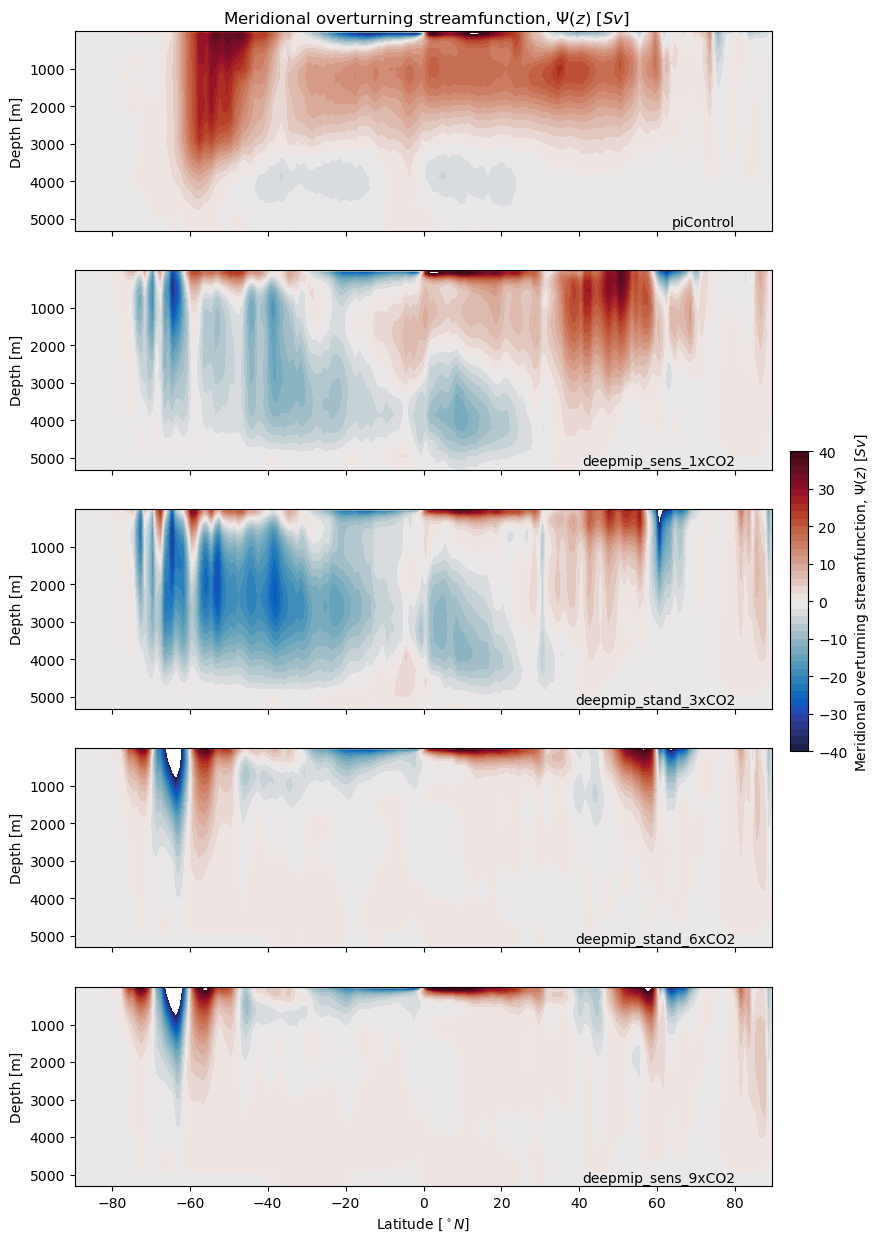

In [154]:
longname = 'Meridional overturning streamfunction, $\Psi(z)$ [$Sv$]'
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

cmap = cmocean.cm.balance
cmap.set_bad(color='darkgrey')
contours = np.arange(-40,41,2)
ne = len(experiments)

fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = (psinow*1e-6).sel(experiment=experiment)
    # sigma2 = dssec.sel(experiment=experiment)['sigma2']
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.contourf(da['y'],da['z'],da,levels=contours,cmap=cmap)
    # cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    # axnow.clabel(cs)
    axnow.text(80,5200,experiment,color='k',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    # im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname)
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

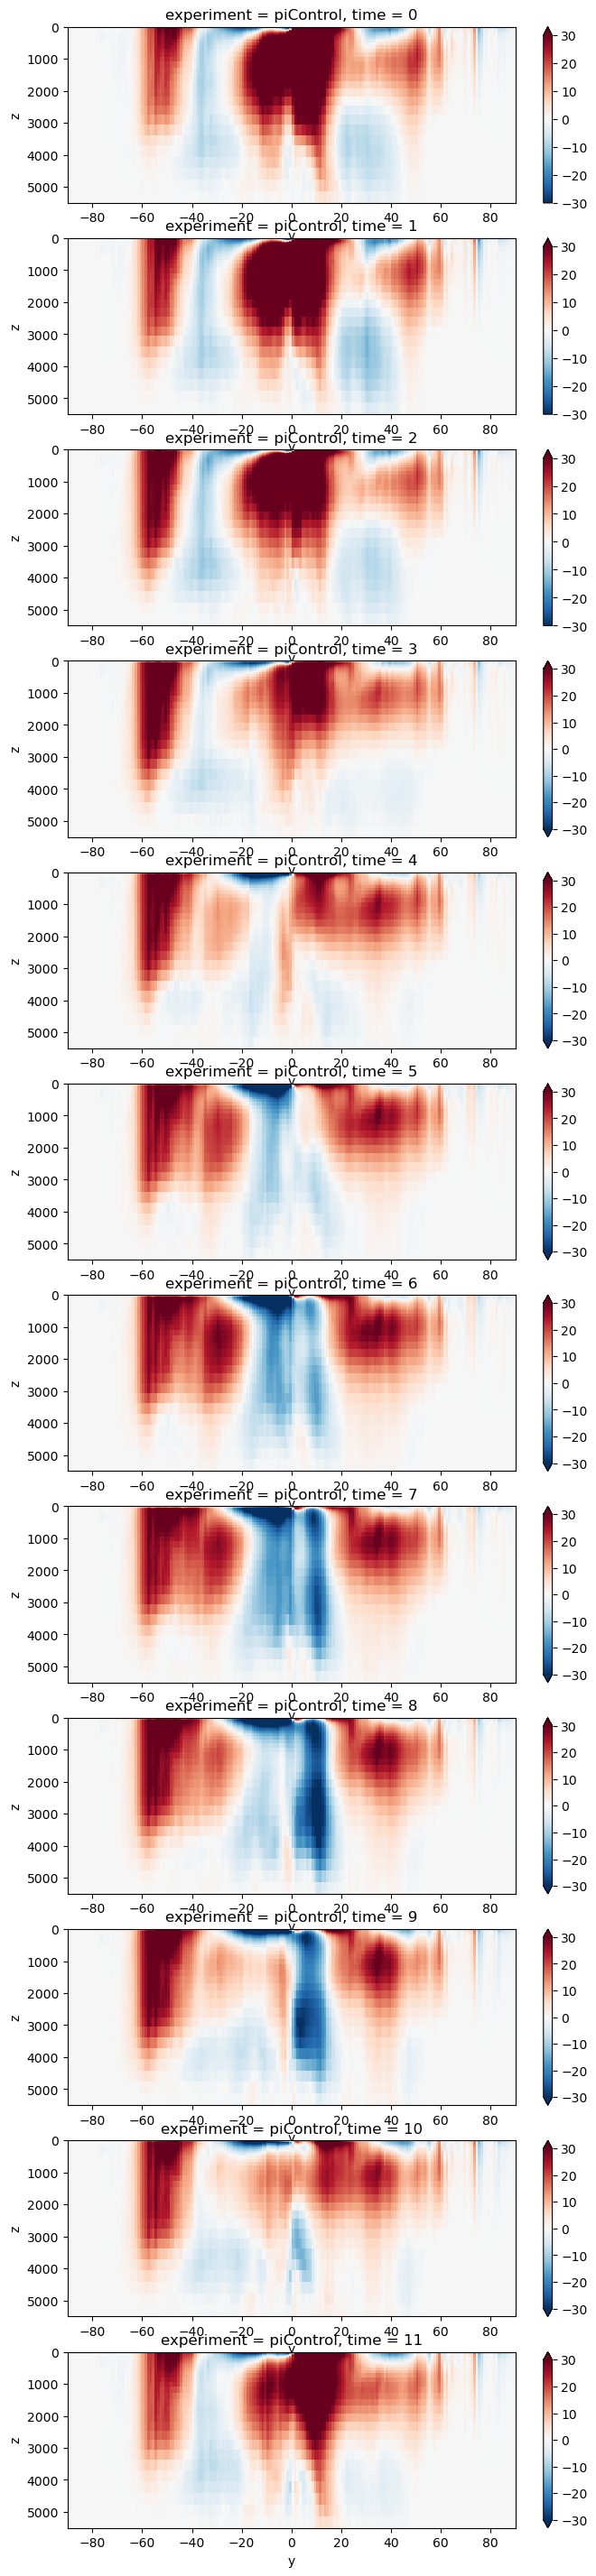

In [42]:
fig,axarr = plt.subplots(figsize=(8,12*3),nrows=12)
for month in range(12):
    (psinow*1e-6).sel(experiment='piControl').isel(time=month).plot(ax=axarr[month], vmin=-30,vmax=30, cmap='RdBu_r')
    axarr[month].invert_yaxis()